In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

In [2]:
import ktrain
from ktrain import text

Using TensorFlow backend.


using Keras version: 2.2.4


# Building an Arabic Sentiment Analyzer

In this notebook, we will build a simple, fast, and accurate Arabic-language text classification model in 4 simple steps. More specifically, we will build a model that classifies Arabic hotel reviews as either positive or negative.

The dataset can be downloaded from Ashraf Elnagar's GitHub repository (https://github.com/elnagara/HARD-Arabic-Dataset).

Each entry in the dataset includes a review in Arabic and a rating between 1 and 5.  We will convert this to a binary classification dataset by assigning reviews with a rating of above 3 a positive label of 1 and assigning reviews with a rating of less than 3 a negative label of 0.

(**Disclaimer:** I don't speak Arabic. Please forgive mistakes.) 



In [3]:
# convert ratings to a binary format:  1=positive, 0=negative
import pandas as pd
df = pd.read_csv('data/arabic_hotel_reviews/balanced-reviews.txt', delimiter='\t', encoding='utf-16')
df = df[['rating', 'review']] 
df['rating'] = df['rating'].apply(lambda x: 'neg' if x < 3 else 'pos')
df.columns = ['label', 'text']
df = pd.concat([df, df.label.astype('str').str.get_dummies()], axis=1, sort=False)
df = df[['text', 'neg', 'pos']]
df.head()

,text,neg,pos
0,“ممتاز”. النظافة والطاقم متعاون.,1,0
1,استثنائي. سهولة إنهاء المعاملة في الاستقبال. ل...,0,1
2,استثنائي. انصح بأختيار الاسويت و بالاخص غرفه ر...,0,1
3,“استغرب تقييم الفندق كخمس نجوم”. لا شي. يستحق ...,1,0
4,جيد. المكان جميل وهاديء. كل شي جيد ونظيف بس كا...,0,1


## STEP 1:  Load and Preprocess the Data

First, we use the `texts_from_df` function to load and preprocess the data in to arrays that can be directly fed into a neural network model. 

We set `val_pct` as 0.1, which will automatically sample 10% of the data for validation.  We specifiy `preprocess_mode='standard'` to employ normal text preprocessing.  If you are using the BERT model (i.e., 'bert'), you should use `preprocess_mode='bert'`.

**Notice that there is nothing speical or extra we need to do here for non-English text.**  *ktrain* automatically detects the language and character encoding and prepares the data and configures the model appropriately.



In [8]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(df, 
                                                                   'text', # name of column containing review text
                                                                   label_columns=['neg', 'pos'],
                                                                   maxlen=75, 
                                                                   max_features=100000,
                                                                   preprocess_mode='standard',
                                                                   val_pct=0.1,
                                                                   ngram_range=3)

language: ar
Word Counts: 151716
Nrows: 95128
95128 train sequences
Average train sequence length: 23
Adding 3-gram features
max_features changed to 2689751 with addition of ngrams
Average train sequence length with ngrams: 66
x_train shape: (95128,75)
y_train shape: (95128,2)
10570 test sequences
Average test sequence length: 22
Average test sequence length with ngrams: 41
x_test shape: (10570,75)
y_test shape: (10570,2)


## STEP 2:  Create a Model and Wrap in Learner Object

We will employ a neural implementation of the [NBSVM](https://www.aclweb.org/anthology/P12-2018/).

In [9]:
model = text.text_classifier('nbsvm', (x_train, y_train) , preproc=preproc)
learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=32)

Is Multi-Label? False
compiling word ID features...
maxlen is 75
building document-term matrix... this may take a few moments...
rows: 1-10000
rows: 10001-20000
rows: 20001-30000
rows: 30001-40000
rows: 40001-50000
rows: 50001-60000
rows: 60001-70000
rows: 70001-80000
rows: 80001-90000
rows: 90001-95128
computing log-count ratios...
done.


## STEP 3: Estimate the LR
We'll use the *ktrain* learning rate finder to find a good learning rate to use with *nbsvm*.  We will, then, select the highest learning rate associated with a still falling loss.


simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
48736/95128 [==============>...............] - ETA: 8s - loss: 0.5553 - acc: 0.7843

done.


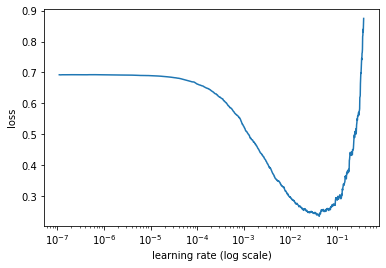

In [10]:
learner.lr_find(show_plot=True)

## STEP 4: Train the Model

We will use the `autofit` method that employs a triangular learning rate policy and train 1 epoch.

As shown in the cell below, our final validation accuracy is **94%** with only ~20 seconds of training over a single epoch!

In [11]:
learner.autofit(5e-3, 1)



begin training using triangular learning rate policy with max lr of 0.005...
Train on 95128 samples, validate on 10570 samples
Epoch 1/1
95128/95128 [==============================] - 21s 219us/step - loss: 0.2227 - acc: 0.9343 - val_loss: 0.1754 - val_acc: 0.9427


### Inspecting Misclassifications

In [12]:
learner.view_top_losses(n=1, preproc=preproc)

----------
id:5338 | loss:13.94 | true:neg | pred:pos)

“ممتاز جدا وأشكر كل العاملين في الفندق ع حسن ممتاز جدا وانصح به من جميع النواحي نظافه وتعامل راقي ومواصلات الي الحرم ه مدار الساعه وإفطار ممتاز وأشكر موظفو الاستقبال ع حسن اسقبالهم مكان مميز وسعر مميز فقطالماء للتعريف


Using Google Translate, the above roughly translates to:
> *The hotel is very clean and the staff are very friendly and helpful.*

This is clearly a positive review and was predicted as positive by our model.  The "ground truth" rating for this review is incorrect and explains the high loss. Perhaps the customer accidently entered a low rating.

### Making Predictions on New Data

In [13]:
p = ktrain.get_predictor(learner.model, preproc)

Predicting label for the text
> "*The room was clean, the food excellent, and I loved the view from my room.*"

In [14]:
p.predict("الغرفة كانت نظيفة ، الطعام ممتاز ، وأنا أحب المنظر من غرفتي.")

'pos'

Predicting label for:
> "*This hotel was too expensive and the staff is rude.*"

In [16]:
p.predict('كان هذا الفندق باهظ الثمن والموظفين غير مهذبين.')

'neg'

### Save our Predictor for Later Deployment

In [17]:
# save model for later use
p.save('/tmp/arabic_predictor')

In [18]:
# reload from disk
p = ktrain.load_predictor('/tmp/arabic_predictor')

In [19]:
# still works as expected after reloading from disk
p.predict("الغرفة كانت نظيفة ، الطعام ممتاز ، وأنا أحب المنظر من غرفتي.")

'pos'